In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal, integrate
import plotly.graph_objects as go
import plotly.io as pio

import matplotlib.pyplot as plt
import matplotlib
# import matplotlib.dates as mdates
# from matplotlib.colors import BoundaryNorm
# from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
# from matplotlib.ticker import MaxNLocator

# import xrft
# import warnings
# warnings.warn('ignore', FutureWarning)
# warnings.simplefilter(action='ignore', category=FutureWarning)

from subroutines import *

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [2]:
fileLocation = '/work/bd0620/b309199/translb3D/translb3D_006'
env_fileName = "env.nc"
tapes_fileName = "tapes.nc" # "tapes.nc"
grid_fileName = "grd.nc"
env_path = os.path.join(fileLocation, env_fileName)
tapes_path = os.path.join(fileLocation, tapes_fileName)
grid_path = os.path.join(fileLocation, grid_fileName)

ds = xr.open_dataset(tapes_path) #, decode_times=False)
# DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
# DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

ds_grid = xr.open_dataset(grid_path)
ds_env = xr.open_dataset(env_path)

if len(ds.w.shape) == 3: # 2D case
    # ds_env['time'] = ds['time']
    ds = ds.drop('time')
    ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
    # ds = ds.drop('ELEVATION')
    ds = ds.expand_dims('y',axis=2)

if len(ds_env.ue.shape) == 3: # not time depedant case
    ds_env = ds_env.expand_dims({'t':ds.t})

ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                      'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
ds_env = ds_env.drop('zcr')
ds = ds.merge(ds_env)

# ---- Sim parameters -------------- # 
ds.attrs = ds_grid.attrs
ds.attrs['bv'] = ds.attrs['bv'].round(3)
ds.attrs['u00'] = ds['ue'][0,0,0,0].values
ds.attrs['v00'] = ds['ve'][0,0,0,0].values
ds.attrs['nx'] = np.shape(ds['w'])[3]
ds.attrs['ny'] = np.shape(ds['w'])[2]
ds.attrs['nz'] = np.shape(ds['w'])[1]

ds = dzdx_topo(ds)
# ---- Sim parameters -------------- # 

# ---- Constants ------------------- #
pref00=101325.
# pref00=23700.
ds.attrs['cp']=3.5*ds.rg # Earth
ds.attrs['grav']=ds.g
ds.attrs['cap']=ds.rg/ds.cp
ds.attrs['capi'] =1/ds.cap
ds.attrs['capp']=1-ds.cap # Cv/Cp
ds.attrs['cappi']=1/ds.capp   # Cp/Cv
ds.attrs['compri']=ds.rg/pref00**ds.cap

ds.attrs['cp'] = np.round(ds.attrs['cp'],3) # .round(3)
ds.attrs['cap'] = np.round(ds.attrs['cap'])
ds.attrs['capp'] = np.round(ds.attrs['capp'])
ds.attrs['compri'] = np.round(ds.attrs['compri'])
# ---- Constants ------------------- # 

# ---- IDL code of AD -------------- # 
# Forces (MF_x, EF_z, EF_x)
# h1: ttt (theta)
# h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
# h3: wprime = w
# h4: tprime+the
# h5: sqrt(uprime^2+vprime^2)
# h6: uprime
# h7: ploc or h12-h12(100), h12=p
# h9: MFx
# h11: EFx
# h12: pprime filtered
# ---- IDL code of AD -------------- #

# ---- Perturbations -- #
# Uncomment line that suits available data
# ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
# ds['uprime'] = ds['u'] - ds['ue']

# ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
# ds['vprime'] = ds['v'] - ds['ve']

# ds['wprime'] = ds['w']

# ---- Pressure ------- #
ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
# p is pressure perturbation output from EULAG
# h12 is 2D filtered
# h7 additionally referenced to x-location before mtn
# ppe=(rhe*the*compri)^cappi
# ds['pprime']=ds['p'] # h12
# ds['pprime']=filt_2dx(ds['p'],1) # h12
# ds['pprime']=filt_2dx(ds['p'],0) # h12
# ds['ploc'] = ds['pprime'] + ds['pr0']
# ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


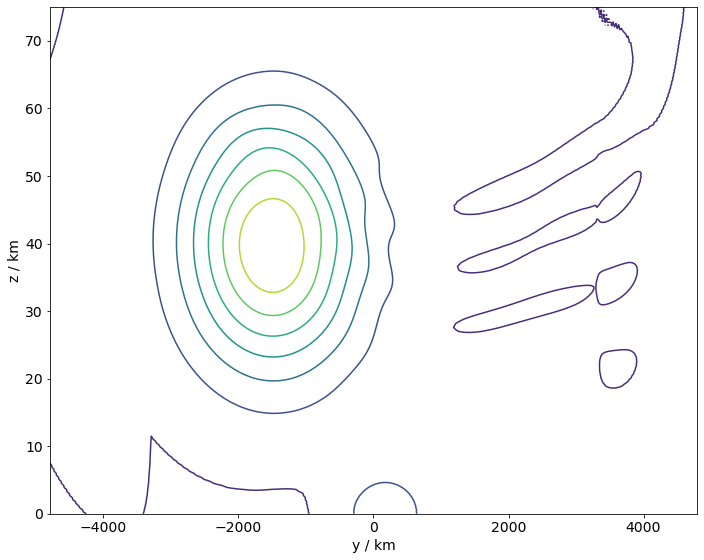

In [3]:
# --- Wind 2D y-z --- #
fig, ax0 = plt.subplots(figsize=(10,8))
t=5
x=int(ds.nx/2)
cont0 = ax0.contour(ds.ycr[:,0],ds.zcr[t,:,0,x],ds['u'][t,:,:,x].values) # levels=[40,50,60,70,80,90])

ax0.set_xlabel('y / km')
ax0.set_ylabel('z / km')

# --- Save fig --- #
fig.tight_layout()
# fig.savefig(SETTINGS['FILE_LOCATION'] + '/' + SETTINGS['PLOT_FOLDER'] + '/' + fig_name, facecolor='w', edgecolor='w',
#             format='png', dpi=150) # orientation='portrait'
        

In [6]:
# --- Plotly volume function --- #
# - allows mapping of opacity to values - # 
t=4
yc = int(ds.ny/2)
xc = int(ds.nx/2)

xlim=50
ylim=50
ztop=150
zbottom=100

xcr = ds.xcr.expand_dims({'z':ds.z},axis=0)
ycr = ds.ycr.expand_dims({'z':ds.z},axis=0)
zcr = ds.zcr[t,:,:,:]
th = ds['th'][t,:,:,:]

xcr = xcr[zbottom:ztop,(yc-ylim):(yc+ylim),(xc-xlim):(xc+xlim)]
ycr = ycr[zbottom:ztop,(yc-ylim):(yc+ylim),(xc-xlim):(xc+xlim)]
zcr = zcr[zbottom:ztop,(yc-ylim):(yc+ylim),(xc-xlim):(xc+xlim)]
th  =  th[zbottom:ztop,(yc-ylim):(yc+ylim),(xc-xlim):(xc+xlim)].transpose().values
X, Y, Z = np.meshgrid(xcr[0,0,:],ycr[0,:,0],zcr[:,0,0])
# X, Y, Z = np.mgrid[-1:1:50j, -1:1:40j, -1:1:30j]
# values =    np.sin(np.pi*X) * np.cos(np.pi*Z) * np.sin(np.pi*Y)

fig = go.Figure(data=go.Volume(
    # x=xcr.transpose().values.flatten(),
    # y=ycr.transpose().values.flatten(), 
    # z=zcr.transpose().values.flatten(),
    # value=th.transpose().values.flatten(),
    x=X.flatten(),
    y=Y.flatten(), 
    z=Z.flatten(),
    value=th.flatten(),
    
    colorscale='RdBu',
    reversescale=True,
    isomin=-10,
    isomax=10,
    
    opacity=0.2, # max opacity
    # opacityscale=[[-10, 1], [-5, 0.75], [-3, 0.5], [-1, 0.25], [-0.2, 0], [0.2, 0], [1, 0.25], [3, 0.5], [5, 0.75], [10, 1]],
    
    surface_count=5,
    # slices_z=dict(show=True, locations=[0,20,40]),
    caps=dict(x_show=False, y_show=False,z_show=True),
    
    ))

"""
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[np.min(xcr),np.max(xcr)],),
        yaxis = dict(nticks=4, range=[np.min(ycr),np.max(ycr)],),
        zaxis = dict(nticks=4, range=[np.min(zcr),np.max(zcr)],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))
"""

fig.update_scenes(xaxis_autorange="reversed") # yaxis_autorange="reversed"

# fig.write_json('../figures/translb3D_002.json')

# fig.write_image("../figures/translb3D_002.png", engine="kaleido")
# fig.write_image("../figures/translb3D_002.pdf")
pio.to_image(fig,"png")
# fig.show()

ValueError: Failed to start Kaleido subprocess. Error stream:

./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.14' not found (required by ./bin/kaleido)
./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.15' not found (required by ./bin/kaleido)
./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.16' not found (required by ./bin/kaleido)
./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.14' not found (required by /pf/b/b309199/kernels/plotly-kernel/lib/python3.8/site-packages/kaleido/executable/lib/libnss3.so)
./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.14' not found (required by /pf/b/b309199/kernels/plotly-kernel/lib/python3.8/site-packages/kaleido/executable/lib/libnssutil3.so)
./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.14' not found (required by /pf/b/b309199/kernels/plotly-kernel/lib/python3.8/site-packages/kaleido/executable/lib/libnspr4.so)
./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.15' not found (required by /pf/b/b309199/kernels/plotly-kernel/lib/python3.8/site-packages/kaleido/executable/lib/libnspr4.so)
./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.17' not found (required by /pf/b/b309199/kernels/plotly-kernel/lib/python3.8/site-packages/kaleido/executable/lib/libnspr4.so)
./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.14' not found (required by /pf/b/b309199/kernels/plotly-kernel/lib/python3.8/site-packages/kaleido/executable/lib/libexpat.so.1)
./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.14' not found (required by /pf/b/b309199/kernels/plotly-kernel/lib/python3.8/site-packages/kaleido/executable/lib/libplc4.so)
./bin/kaleido: /lib64/libc.so.6: version `GLIBC_2.14' not found (required by /pf/b/b309199/kernels/plotly-kernel/lib/python3.8/site-packages/kaleido/executable/lib/libplds4.so)


In [ ]:
pio.orca.status

In [ ]:
# -- Isosurface -- #
"""
fig= go.Figure(data=go.Isosurface(
    x=xcr.transpose().values.flatten(),
    y=ycr.transpose().values.flatten(),
    z=Z.flatten(), #zcr.transpose().values.flatten(),
    value=th.transpose().values.flatten(),
    colorscale='BlueRed',
    opacity=0.6,
    isomin=-3,
    isomax=3,
    surface_count=4,
#    slices_z=dict(show=True, locations=[0,20,40]),
    caps=dict(x_show=False, y_show=False,z_show=False),
))
fig.show()
"""

In [ ]:
# --- Save figure --- #
# fig.suptitle(title_label)
# fig.tight_layout()
# fig.savefig('../Figures/' + fig_title, facecolor='w', edgecolor='w',
#                 format='png', dpi=150)